<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Alireza Abbasian
### Student ID: 402200253

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))  
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize) 

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')  
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

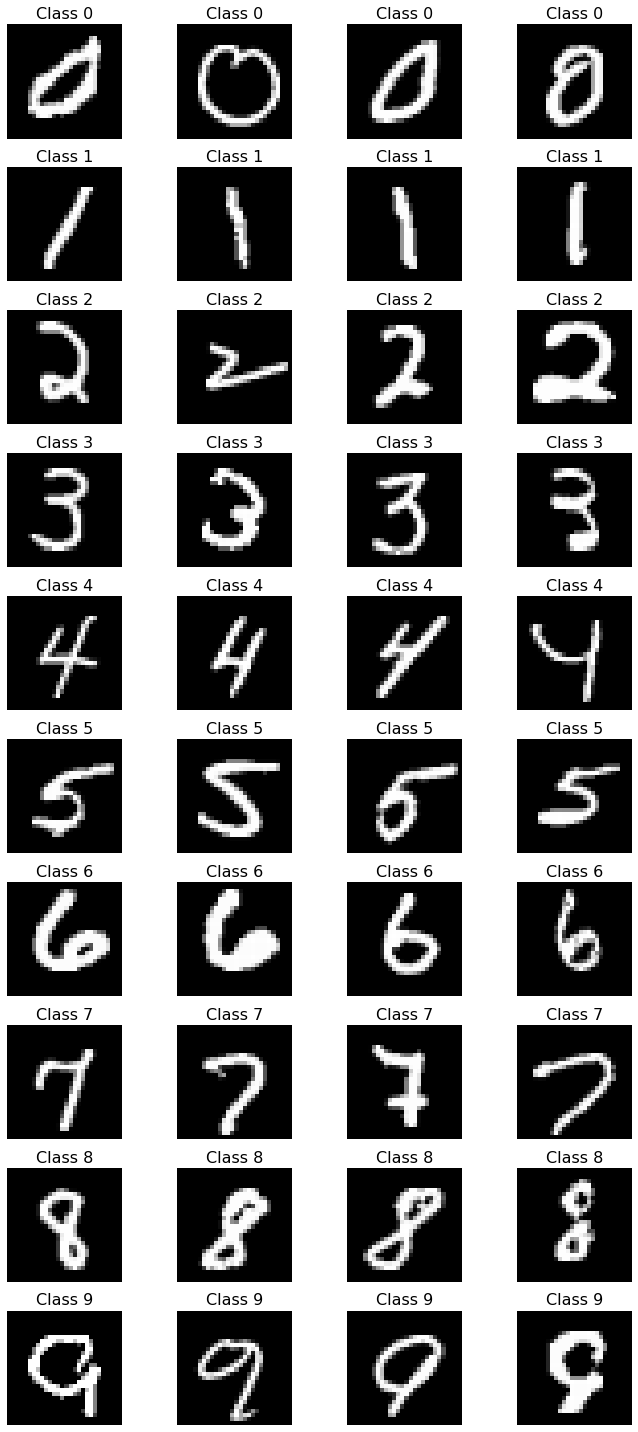

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP) 

Let's get started!

# 1) VAE --> MLP

<div dir="rtl">
<font face="B Nazanin" size="5">
توجه کنید که 
من فرض کرده ام
متغیر ورودی 
hidden_dim
یک لیستی از اعداد است که هر عدد در این لیست نشان دهنده تعداد نورون های یک لایه مخفی می باشد.
</font>
</div>

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim, hidden_dim[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1):
            encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)

        self.fc_mu = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[-1], latent_dim)

        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, hidden_dim[-1]))
        decoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dim[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        recon_x = self.decoder(z)

        return recon_x, mu, logvar, z



In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):

    reconstruction_loss = nn.functional.binary_cross_entropy(recon.view(-1, 28*28), data.view(-1, 28*28), reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = (reconstruction_loss + kl_divergence) / data.size(0)
    return total_loss

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=7, learning_rate=1e-3):
    device = next(model.parameters()).device  # Get the device of the model
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for (data, _) in tqdm(train_loader):
            data = data.to(device)  # Move data to the specified device
            optimizer.zero_grad()

            data = data.view(-1, 28*28)
            recon, mu, logvar, _ = model(data)

            recon = recon.view(-1, 28*28)

            loss = vae_loss(recon, data, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################


100%|██████████| 938/938 [00:13<00:00, 71.56it/s]


VAE-MLP Epoch [1/7], Loss: 2.726833696746826
Sample Images:


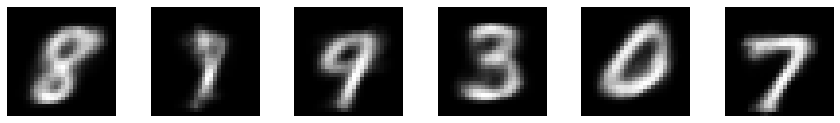


##################################################


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]

VAE-MLP Epoch [2/7], Loss: 2.3764350560506187
Sample Images:


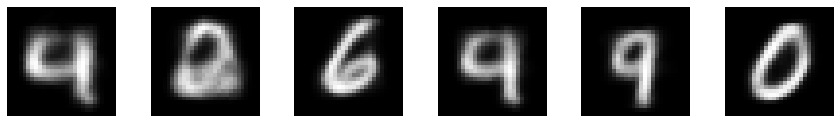


##################################################


100%|██████████| 938/938 [00:11<00:00, 84.11it/s]


VAE-MLP Epoch [3/7], Loss: 2.297986870829264
Sample Images:


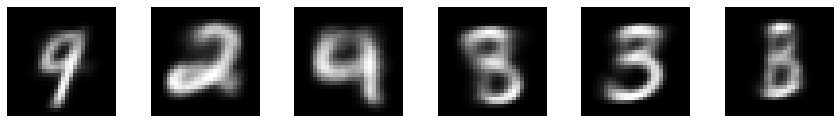


##################################################


100%|██████████| 938/938 [00:11<00:00, 83.91it/s]


VAE-MLP Epoch [4/7], Loss: 2.265066739018758
Sample Images:


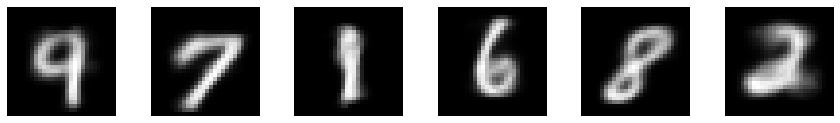


##################################################


100%|██████████| 938/938 [00:11<00:00, 82.75it/s]


VAE-MLP Epoch [5/7], Loss: 2.2391312999725344
Sample Images:


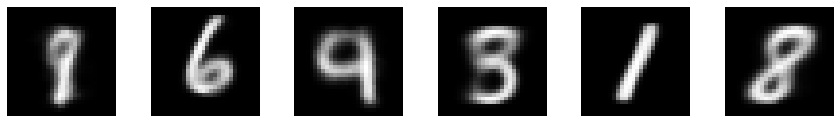


##################################################


100%|██████████| 938/938 [00:11<00:00, 80.18it/s]

VAE-MLP Epoch [6/7], Loss: 2.231823410924276
Sample Images:


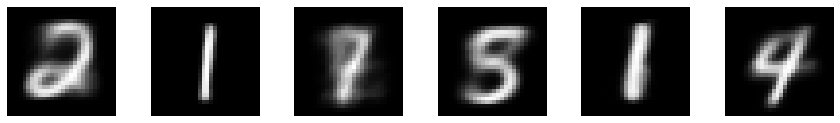


##################################################


100%|██████████| 938/938 [00:11<00:00, 79.35it/s]


VAE-MLP Epoch [7/7], Loss: 2.2100547417958576
Sample Images:


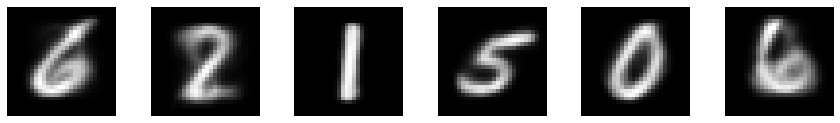

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP

input_dim = 784  
hidden_dim = [1000,500,250]  # based on slides!
latent_dim = 2

vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
vae_mlp = vae_mlp.to(device)

train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

<div dir="rtl">
<font face="B Nazanin" size="5">
توجه کنید که من برای 
fc_class
صرفا یک لایه 
identity
گذاشتم که بردار وان هات کلاس را بدون تغییر  برمیگرداند.
این کار را عملکرد بهتری از گذاشتن یک لایه 
fully connected
داشت.

یعنی در ورودی انکودر بردار تصویر ورودی که flatten
شده است و بردار وان هات کلاس را به صورت پشت سر هم قرار می دهیم.
خروجی انکودر هم که میانگین و واریانس است و پس از سمپل گرفتن و reparameterize
کردن دوباره بردار وان هات کلاس را به سمپل reparemeterized
اضافه می کنیم و به دیکودر می دهیم.
</font>
</div>

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim + num_classes, hidden_dim[0]))
        encoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1):
            encoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        self.fc_mu = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim[-1], latent_dim)
        self.fc_class = nn.Identity()

        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim + num_classes, hidden_dim[-1]))
        decoder_layers.append(nn.ReLU())
        for i in range(len(hidden_dim) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dim[i], hidden_dim[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dim[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):

        x = torch.cat([x, y], dim=1)

        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)

        class_logits = self.fc_class(y)
        zy = torch.cat([z, class_logits], dim=1)

        reconstructed = self.decoder(zy)

        return reconstructed, mu, logvar, class_logits, z


In [10]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):

    reconstruction_loss = nn.functional.binary_cross_entropy(recon.view(-1, 28*28), data.view(-1, 28*28), reduction='sum')

    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    total_loss = (reconstruction_loss + kl_divergence + ce_loss) / data.size(0)
    return total_loss


In [11]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    device = next(model.parameters()).device  # Get the device of the model
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for (data, labels) in tqdm(train_loader):
            data = data.to(device)  # Move data to the specified device
            labels = labels.to(device)
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            data = data.view(-1, 28*28)
            recon, mu, logvar, class_logits, _ = model(data, labels_one_hot)

            recon = recon.view(-1, 28*28)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################


  1%|          | 6/938 [00:00<00:16, 57.87it/s]

100%|██████████| 938/938 [00:12<00:00, 76.49it/s]


CVAE-MLP Epoch [1/10], Loss: 2.476760185877482
Sample Images:


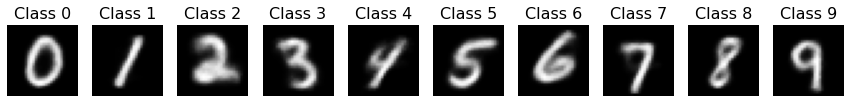


##################################################


100%|██████████| 938/938 [00:11<00:00, 78.80it/s]


CVAE-MLP Epoch [2/10], Loss: 2.141804881540934
Sample Images:


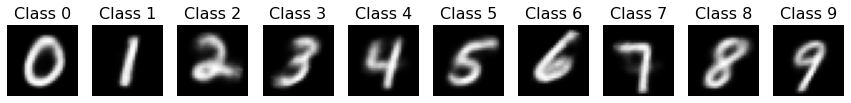


##################################################


100%|██████████| 938/938 [00:12<00:00, 76.94it/s]


CVAE-MLP Epoch [3/10], Loss: 2.101982173919678
Sample Images:


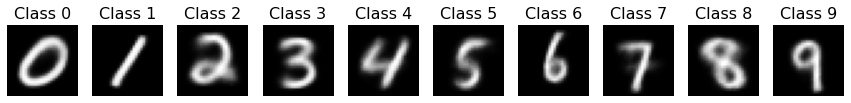


##################################################


100%|██████████| 938/938 [00:12<00:00, 77.46it/s]


CVAE-MLP Epoch [4/10], Loss: 2.081133840560913
Sample Images:


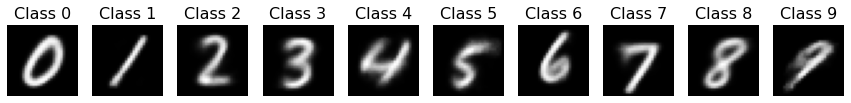


##################################################


100%|██████████| 938/938 [00:12<00:00, 75.01it/s]


CVAE-MLP Epoch [5/10], Loss: 2.067102883911133
Sample Images:


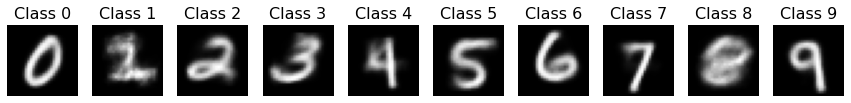


##################################################


100%|██████████| 938/938 [00:12<00:00, 73.93it/s]


CVAE-MLP Epoch [6/10], Loss: 2.058599094518026
Sample Images:


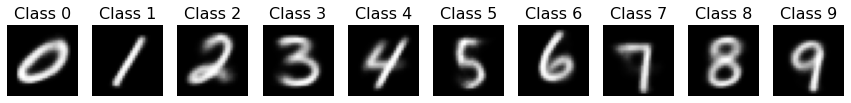


##################################################


100%|██████████| 938/938 [00:12<00:00, 78.10it/s]


CVAE-MLP Epoch [7/10], Loss: 2.050290839131673
Sample Images:


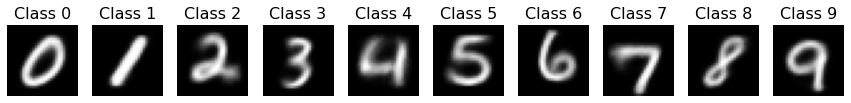


##################################################


100%|██████████| 938/938 [00:12<00:00, 76.36it/s]


CVAE-MLP Epoch [8/10], Loss: 2.042930316034953
Sample Images:


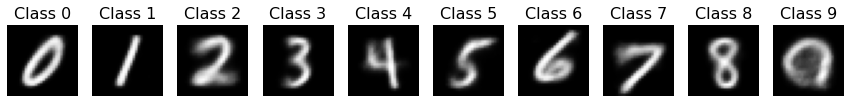


##################################################


100%|██████████| 938/938 [00:12<00:00, 74.65it/s]


CVAE-MLP Epoch [9/10], Loss: 2.037142239634196
Sample Images:


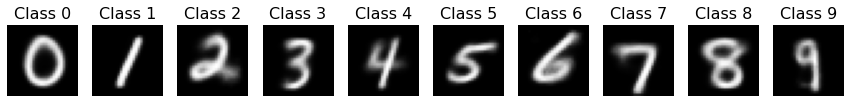


##################################################


100%|██████████| 938/938 [00:12<00:00, 73.25it/s]


CVAE-MLP Epoch [10/10], Loss: 2.032484936014811
Sample Images:


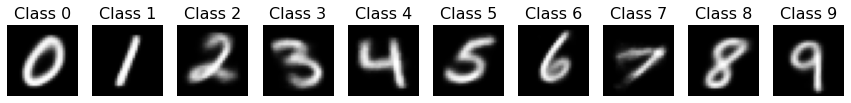

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
input_dim = 784  
hidden_dim = [1000,500,250]  # based on slides!
latent_dim = 2

cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes=10)
cvae_mlp = cvae_mlp.to(device)

train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


<div dir="rtl">
<font face="B Nazanin" size="5">
تابع 
get_latents
را به این صورت نوشته ام که مدل و دیتا لودر را در ورودی میگیرد و به تعداد نمونه مشخص شده در ورودی
از دیتا لودر دیتا برمیدارد به مدل میدهد و بردار latent
ها را برمیگرداند.
همچنین لیبل نظیر هر latent
را هم برمیگرداند.

در زیر مدل های
vae, cvae
را که ذخیره کرده بودیم را لود میکنیم.
</font>
</div>

In [13]:
num_classes=10
# Load the models
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

vae_mlp.load_state_dict(torch.load('best_vae_mlp_model.pth'))
cvae_mlp.load_state_dict(torch.load('best_cvae_mlp_model.pth'))
vae_mlp = vae_mlp.to(device)
cvae_mlp = cvae_mlp.to(device)

vae_mlp.eval()
cvae_mlp.eval()

# Define a function to get latent representations from the encoder
def get_latents(model, data_loader, max_num_samples=1000):
    latents = []
    labels_of_latents = []
    num_samples = 0

    for batch_idx, (data, label) in enumerate(data_loader):
        if num_samples >= max_num_samples:
            break
        num_samples += data.size(0)

        data = data.to(device)  # Move data to the specified device
        label = label.to(device)
        data = data.view(-1, 28*28)
        with torch.no_grad():
            if isinstance(model, CVAE_MLP):
                labels_one_hot = F.one_hot(label, num_classes=10).float()
                _, _, _, _, z = model(data, labels_one_hot)
            else:
                _, _, _, z = model(data)

        latents.append(z.cpu())
        labels_of_latents.append(label.cpu())

    latents = np.concatenate(latents, axis=0)
    labels_of_latents = np.concatenate(labels_of_latents, axis=0)
    return latents, labels_of_latents

# Get latent representations from both models
vae_mlp_latents, vae_mlp_labels = get_latents(vae_mlp, train_loader)
cvae_mlp_latents, cvae_mlp_labels = get_latents(cvae_mlp, train_loader)


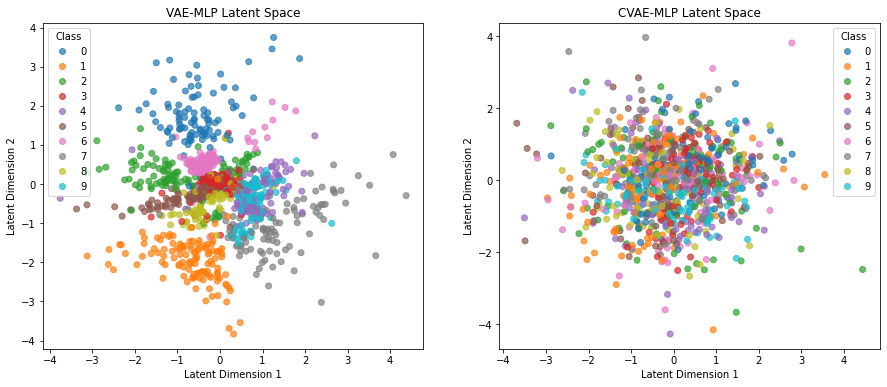

In [14]:
# Plot the latent space distributions
fig, axs = plt.subplots(1, 2, figsize=(15, 6))


# Plot VAE-MLP latent space with tab10 colormap
scatter_vae = axs[0].scatter(vae_mlp_latents[:, 0], vae_mlp_latents[:, 1], c=vae_mlp_labels, cmap='tab10', label='VAE-MLP', alpha=0.7)
axs[0].set_title('VAE-MLP Latent Space')
axs[0].set_xlabel('Latent Dimension 1')
axs[0].set_ylabel('Latent Dimension 2')

# Plot CVAE-MLP latent space with tab10 colormap
scatter_cvae = axs[1].scatter(cvae_mlp_latents[:, 0], cvae_mlp_latents[:, 1], c=cvae_mlp_labels[:], cmap='tab10', label='CVAE-MLP', alpha=0.7)
axs[1].set_title('CVAE-MLP Latent Space')
axs[1].set_xlabel('Latent Dimension 1')
axs[1].set_ylabel('Latent Dimension 2')

# Add legends
legend_labels = [str(i) for i in range(10)]  # Assuming 10 classes
axs[0].legend(handles=scatter_vae.legend_elements()[0], labels=legend_labels, title='Class')
axs[1].legend(handles=scatter_cvae.legend_elements()[0], labels=legend_labels, title='Class')

plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
برای هر کدام از مدل ها 1000 نمونه از دیتا لودر گرفته و بردار های latent
را بدست آورده ام.
در بالا مشاهده میکنید که در 
VAE
توزیع همه کلاس ها در مجموع تقریبا یک توزیع N(0,1) می باشد.
چرا که شکل توزیع تقریبا دایره ای است و 
با دقت خوبی اکثر تراکم داده ها در دایره با شعاع یک قرار میگیرد.
اما باید توجه داشت که داده های کلاس های مختلف 
در VAE
از هم جدا شده اند و هر کلاس در یک ناحیه از دایره قرار دارد.
پس توزیع شرطی داده ها دیگر نرمال صفر و یک نیست.

اما در 
CVAE
توزیع شرطی داده ها نرمال صفر و یک است.
همان طور که میبینید داده های هر کلاس هر کدام برای خود شکل دایره گرفته اند و همه داده های کلاس های مختلف روی هم قرار گرفته اند.
پس توزیع شرطی داده ها نرمال صفر و یک است.
</font>
</div>

<div dir="rtl">
<font face="B Nazanin" size="5">
با اجرای بلوک زیر ده سمپل رندوم از توزیع نرمال صفر و یک  درست کرده و به دیکودر vae
میدهیم تا مانند یک generator
عمل کند و تصویر تولید کند.
</font>
</div>

generated images using vae:


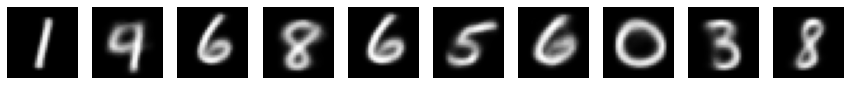

In [15]:
print("generated images using vae:")
num_samples = 10
with torch.no_grad():
    sample = torch.randn(num_samples, 2).to(device)
    sample = vae_mlp.decoder(sample).view(num_samples, 1, 28, 28)
    sample = sample.squeeze().cpu()
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
    for i in range(num_samples):
        axs[i].imshow(sample[i], cmap='gray')
        axs[i].axis('off')
    plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
با اجرای بلوک زیر برای هر کلاس پنج سمپل رندوم از توزیع نرمال صفر و یک  درست کرده و به دیکودر cvae
میدهیم تا مانند یک generator
عمل کند و تصویر تولید کند.
</font>
</div>

generated images using cvae:


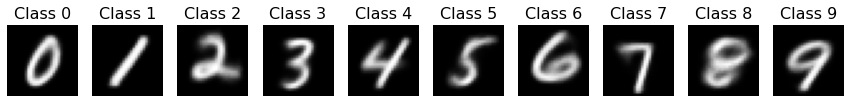

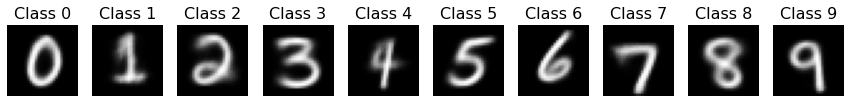

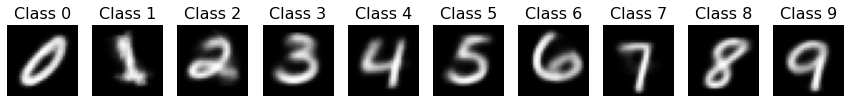

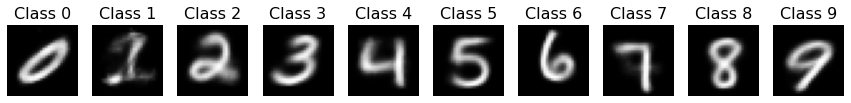

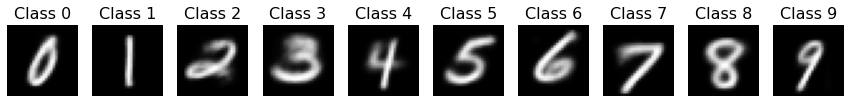

In [16]:
print("generated images using cvae:")
with torch.no_grad():
    for _ in range(5):
        num_classes = 10  # Number of classes (0 to 9)
        num_samples_per_class = 1  # One sample per class
        # Generate random samples
        z = torch.randn(num_classes * num_samples_per_class, 2).to(device)
        # Generate one-hot encoded class labels
        y = torch.eye(num_classes).repeat(num_samples_per_class, 1).to(device)
        # Concatenate the random samples and class labels before passing them to the decoder
        sample = torch.cat([z, y], dim=1)
        sample = cvae_mlp.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
        sample = sample.squeeze().cpu()
        fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
        for i in range(num_classes):
            axs[i].imshow(sample[i], cmap='gray')
            axs[i].set_title(f"Class {i}", fontsize=16)
            axs[i].axis('off')
        plt.show()

<div dir="rtl">
<font face="B Nazanin" size="5">
در 
cell
زیر میتوانید اعداد ترکیبی درست کنید 
مثلا همانطور که در زیر میبینید به جای بردار
one hot
به شکل احتمالی برای هر کلاس احتمالی در نظر میگیریم
مثلا در زیر 5 تصویر تولید کرده ایم که نصف 8 هستند و نصف صفر!
</font>
</div>

generated mix images using cvae:


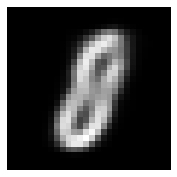

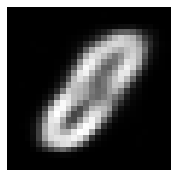

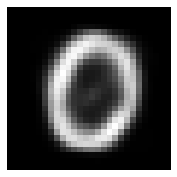

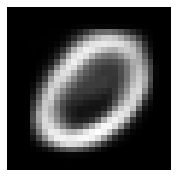

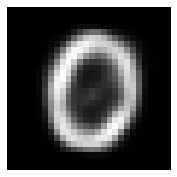

In [17]:
print("generated mix images using cvae:")
with torch.no_grad():
    for _ in range(5):

        # Generate random sample
        z = torch.randn(1, 2).to(device)
        
        # prob labels =   [0  , 1  , 2  , 3  , 4  , 5  , 6  , 7  , 8  , 9  ]
        y = torch.tensor([[0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0]]).float().to(device)

        # Concatenate the random samples and class labels before passing them to the decoder
        sample = torch.cat([z, y], dim = 1)
        sample = cvae_mlp.decoder(sample).view(1, 1, 28, 28)
        sample = sample.squeeze().cpu()
        plt.figure(figsize=(3,3))
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.show()